In [409]:
import pandas as pd
import tensorflow as tf
import numpy as np
import keras
from random import sample, shuffle
from math import floor
from matplotlib import pyplot as plt
from sklearn.preprocessing import scale

In [410]:
class Dense(tf.Module):  # Denesly connected leyer
    # Note: No need for `in_features`
    def _linear_act(x):
        return x

    def __init__(self, out_features, act_func=_linear_act, name=None):
        super().__init__(name=name)
        self.is_built = False
        self.out_features = out_features  # Number of outputs
        self.act_func = act_func  # Activation function

    def __call__(self, x):
        # Create variables on first call.
        if not self.is_built:
            self.w = tf.Variable(tf.random.normal(
                [x.shape[-1], self.out_features]),
                name='w')
            self.b = tf.Variable(tf.zeros([self.out_features]), name='b')
            self.is_built = True

        y = tf.matmul(x, self.w) + self.b
        return self.act_func(y)


class Model(tf.Module):
    def __init__(self, layers=[], name=None):
        super().__init__(name=name)
        self.layers = layers

    # Feed forward on call
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


def _loss(model, inputs, target_y):
    pred_y = model(inputs)
    return tf.reduce_mean(tf.square(target_y - pred_y))


def _grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = _loss(model, inputs, targets)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)


def _get_batches(X, Y, batch_size):
    n_data = len(X)
    # Shuffle data
    c = list(zip(X, Y))
    shuffle(c)
    X, Y = zip(*c)
    # Splitting into batches
    X, Y = np.array(X).astype('float32'), np.array(Y).astype('float32')
    x, y = [], []
    for i in range(0, n_data - batch_size, batch_size):
        x.append(X[i:i + batch_size])
        y.append(Y[i:i + batch_size])
    return x, y


def train(model,
          X,
          Y,
          epochs=10,
          batch_size=1,
          optimiser=tf.optimizers.Adam(0.01)):

    train_loss_results = []
    valid_loss_results = []
    test_loss_results = []

    for epoch in range(epochs):
        ##STATS##
        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_loss_valid = tf.keras.metrics.Mean()
        epoch_loss_test = tf.keras.metrics.Mean()
        ##STATS##
        # Creating new batches for every epoch
        x, y = _get_batches(X, Y, batch_size)
        for i in range(0, len(x)):  # For all each batch
            loss_value, grads = _grad(model, x[i], y[i])
            ##STATS##
            epoch_loss_avg.update_state(loss_value)
            epoch_loss_valid.update_state(_loss(model, x_valid, y_valid))
            epoch_loss_test.update_state(_loss(model, x_test, y_test))
            ##STATS##
            optimiser.apply_gradients(zip(grads, model.trainable_variables))

        train_loss_results.append(epoch_loss_avg.result().numpy())
        valid_loss_results.append(epoch_loss_valid.result().numpy())
        test_loss_results.append(epoch_loss_test.result().numpy())
        if ((epoch + 1) % 10 == 0):
            print("Epoch: {}; Loss: {}".format(
                epoch + 1,
                epoch_loss_avg.result().numpy()))
    return (train_loss_results, valid_loss_results, test_loss_results)

In [411]:
P_TRAIN = 0.92  # Fraction of dataset
P_VALID = 0.04

arecibo_df = pd.read_csv('Arecibo_DF')
nancay_df = pd.read_csv('Nancay_DF')

x_values = arecibo_df.drop(['MHI', 'Name'], axis=1).values.astype('float32')
x_values = scale(x_values)
y_values = arecibo_df['MHI'].values.astype('float32')
y_values = np.reshape(y_values, (-1, 1))

n_data = len(x_values)
n_train = floor(n_data*P_TRAIN)
n_valid = floor(n_data*P_VALID)

c = list(zip(x_values, y_values))
shuffle(c)
x_shuf, y_shuf = zip(*c)

x_train, y_train = x_shuf[0:n_train], y_shuf[0:n_train]
x_valid, y_valid = x_shuf[n_train:n_train +
                            n_valid], y_shuf[n_train:n_train + n_valid]
x_test, y_test = x_shuf[n_train + n_valid:n_data], y_shuf[n_train + n_valid:n_data]


C:\Users\Gordei\anaconda3\envs\tf_env\lib\site-packages\sklearn\preprocessing\_data.py:194: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\Gordei\anaconda3\envs\tf_env\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [451]:

adam_model = Model([Dense(8, tf.nn.sigmoid),
               Dense(16, tf.nn.sigmoid), 
               Dense(16, tf.nn.sigmoid), 
               Dense(1)])
adam_results = train(adam_model, x_train, y_train, epochs=1000,
                batch_size=8, optimiser=tf.optimizers.Adam(0.01))


Epoch: 10; Loss: 0.09602302312850952
Epoch: 20; Loss: 0.04764154180884361
Epoch: 30; Loss: 0.03538276627659798
Epoch: 40; Loss: 0.023215176537632942
Epoch: 50; Loss: 0.018024934455752373
Epoch: 60; Loss: 0.014665268361568451
Epoch: 70; Loss: 0.013810688629746437
Epoch: 80; Loss: 0.011765321716666222
Epoch: 90; Loss: 0.010236089117825031
Epoch: 100; Loss: 0.010012989863753319
Epoch: 110; Loss: 0.010055134072899818
Epoch: 120; Loss: 0.010536213405430317
Epoch: 130; Loss: 0.008716405369341373
Epoch: 140; Loss: 0.006772296037524939
Epoch: 150; Loss: 0.009005832485854626
Epoch: 160; Loss: 0.007357789669185877
Epoch: 170; Loss: 0.0053909351117908955
Epoch: 180; Loss: 0.00843288004398346
Epoch: 190; Loss: 0.005313992500305176
Epoch: 200; Loss: 0.005789699964225292
Epoch: 210; Loss: 0.006909198593348265
Epoch: 220; Loss: 0.004817672539502382
Epoch: 230; Loss: 0.00416986458003521
Epoch: 240; Loss: 0.005432076286524534
Epoch: 250; Loss: 0.004519226960837841
Epoch: 260; Loss: 0.004551363177597523

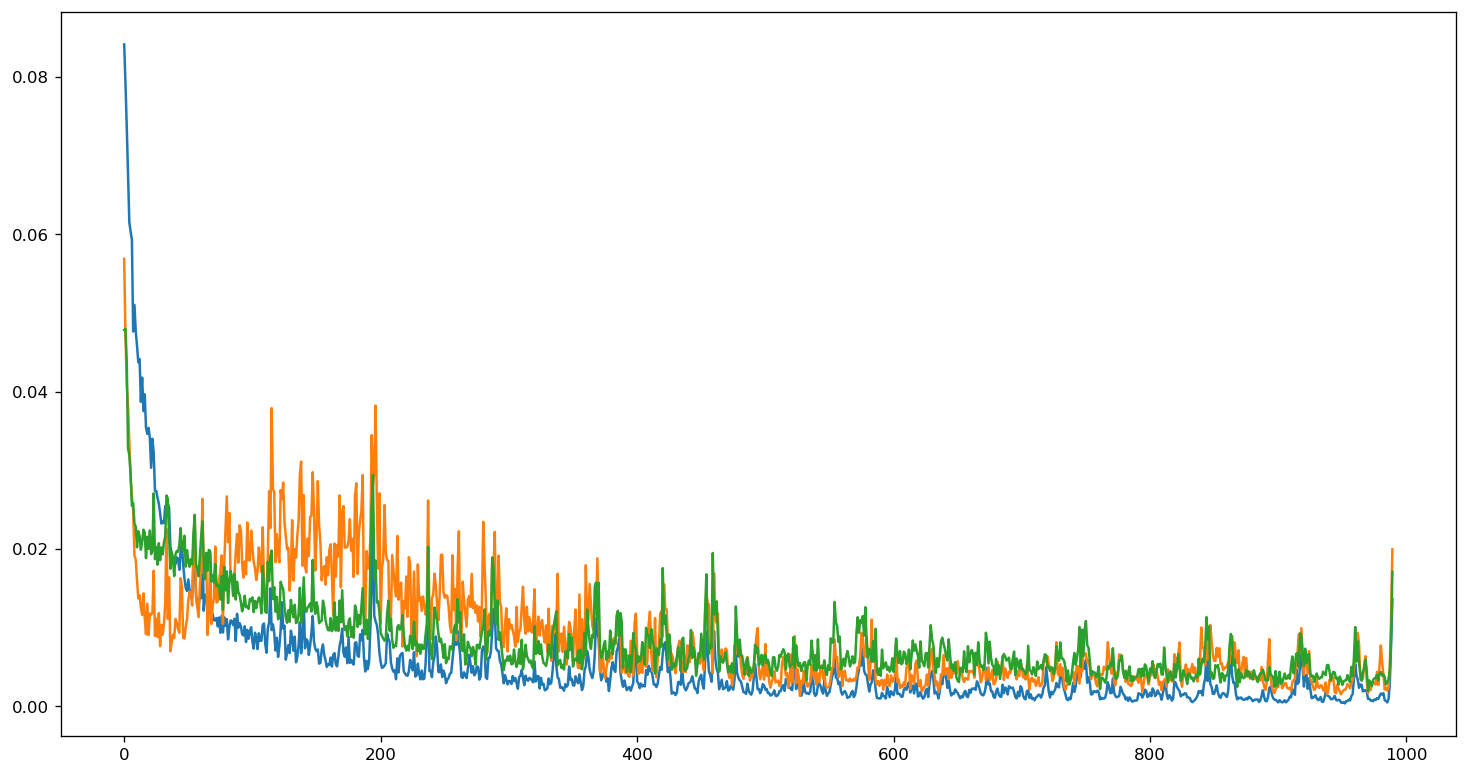

In [462]:
plt.figure(dpi=120, figsize=(15, 8))
plt.plot(adam_results[0][10:])
plt.plot(adam_results[1][10:])
plt.plot(adam_results[2][10:])


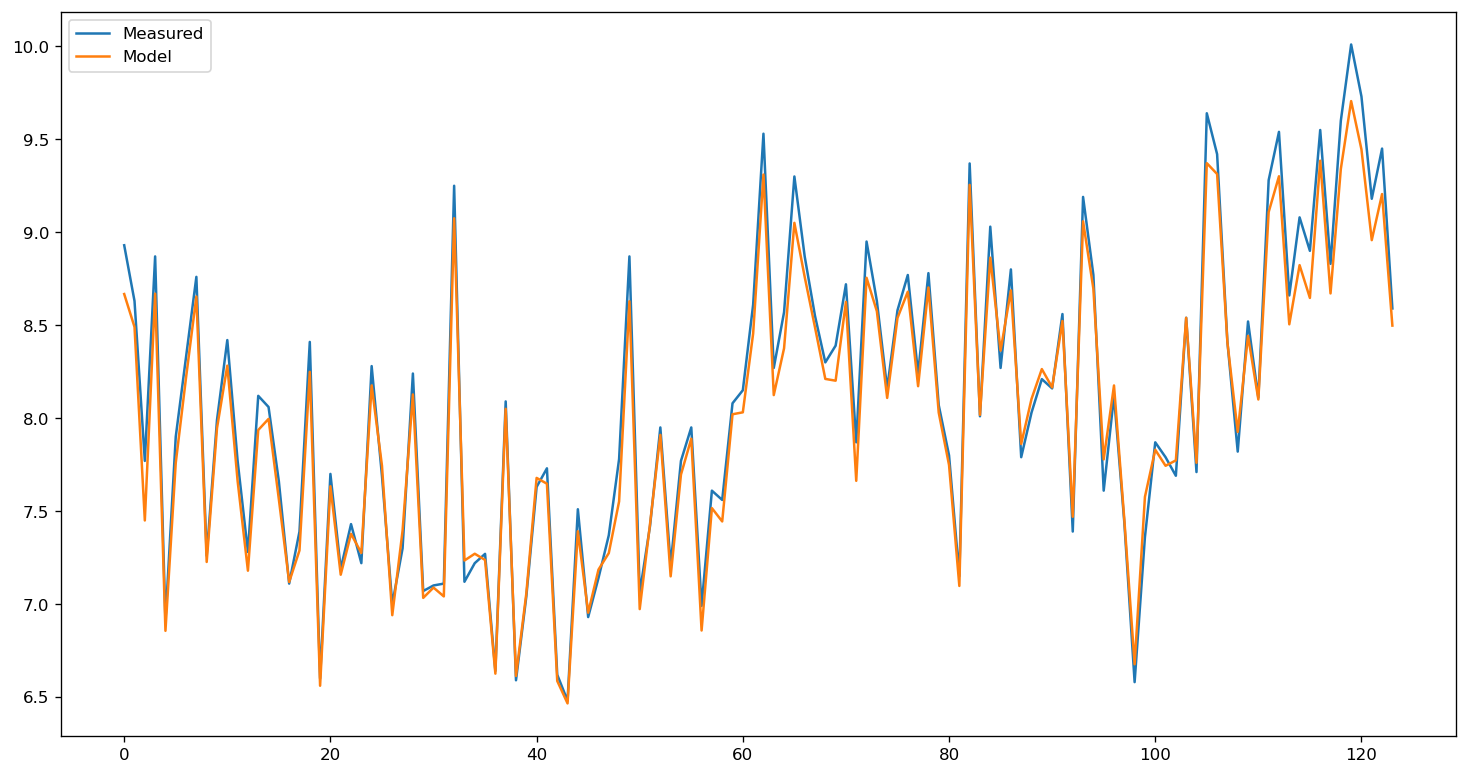

In [463]:
y_pred = adam_model(x_values)
y = y_values
plt.figure(dpi=120, figsize=(15, 8))
measured_l, = plt.plot(range(0, len(y)), y)
model_l, = plt.plot(range(0, len(y)), y_pred)
plt.legend([measured_l, model_l], ('Measured', 'Model'))
plt.show()

In [464]:
nancay_x = nancay_df.drop(['Name', 'MHI'], axis=1).values.astype('float32')
nancay_x = scale(nancay_x)

nancay_y = nancay_df['MHI'].values 
nancay_y = nancay_y

C:\Users\Gordei\anaconda3\envs\tf_env\lib\site-packages\sklearn\preprocessing\_data.py:194: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\Gordei\anaconda3\envs\tf_env\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


                        Name  Vopt   g-z   gMAG     M*   sSFR   rms   VHI  \
0               KUG 2357+156  6000  0.97 -19.39   9.74  -9.96  1.38  6009   
1               CGCG 382-016  7396  1.11 -20.20  10.18 -10.15  2.65  7397   
2                 ASK 146570  1714 -0.18 -14.79   6.76  -8.37  1.57  1705   
3               CGCG 433-016  6352  0.80 -19.61   9.57  -9.75  2.84  6365   
4                PGC 4567836  5131  0.72 -17.24   8.67  -9.77  2.37  5142   
...                      ...   ...   ...    ...    ...    ...   ...   ...   
1846  2MASXi J2340427-092336  5160  0.67 -18.36   9.01  -9.62  2.25  5159   
1847            CGCG 381-031  6627  1.42 -19.51  10.25 -11.93  1.43  6607   
1848                NGC 7739  6605  1.45 -20.33  10.63 -11.84  1.75  6666   
1849            KUG 2346+156  7848  0.96 -19.67   9.93 -10.10  2.57  7804   
1850              ASK 146293  5994  0.61 -17.14   8.55  -9.64  1.57  5991   

      W50   FHI   S/N   MHI  
0     214  0.67   5.4  9.06  
1     233  2.50

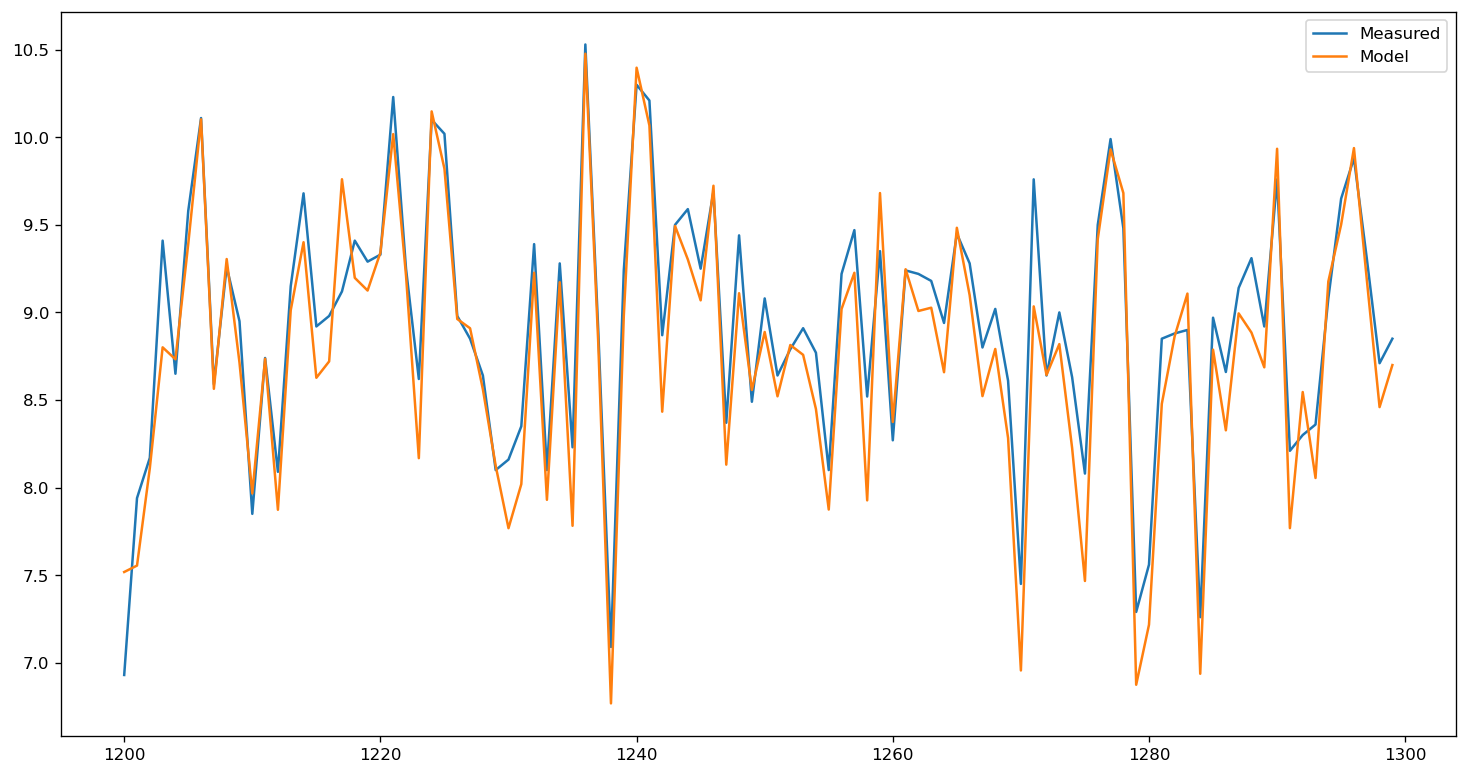

In [465]:
strt = 1200
ran = 100
print(nancay_df)
nancay_x_sub = nancay_x[strt:ran+strt]
nancay_y_sub = nancay_y[strt:ran + strt]
nancay_pred_y = adam_model(nancay_x_sub)

plt.figure(dpi=120, figsize=(15, 8))
measured_l, = plt.plot(range(strt, ran + strt), nancay_y_sub)
model_l, = plt.plot(range(strt, ran + strt), nancay_pred_y + (np.mean(nancay_y) - arecibo_df['MHI'].mean()))
plt.legend([measured_l, model_l], ('Measured', 'Model'))
plt.show()

In [466]:
nancay_pred = adam_model(nancay_x)
print("Nancay prediction mean: " + str(np.mean(nancay_pred)))
print("Nancay observation mean: " + str(np.mean(nancay_y)))

print("Arecibo prediction mean: " + str(np.mean(adam_model(x_values))))
print("Arecibo observation mean: " + str(arecibo_df['MHI'].mean()))

Nancay prediction mean: 7.877083
Nancay observation mean: 8.904921663965425
Arecibo prediction mean: 7.997345
Arecibo observation mean: 8.074596774193548


In [467]:
print(arecibo_df.mean(axis = 0))
arecibo_means = arecibo_df.mean(axis =0)
#arecibo_means = scale(arecibo_means)
ar_mhi_mean = arecibo_means[10]
def calculate_distance(mean, value):
    return np.sum(value-mean)

Vopt    2808.370968
g-z        0.607258
gMAG     -15.931290
M*         8.039701
sSFR      -9.783953
rms        0.561290
VHI     2810.572581
W50       96.379032
FHI        1.041371
S/N       28.317823
MHI        8.074597
dtype: float64


In [468]:
nancay_values = nancay_df.drop('Name', axis = 1).values
#nancay_values = scale(nancay_values)
sample_size = 100
max_distance = 2
acc_dev= 0.2



best_value_index = 0 
last_dist = 0
sample = []
to_ignore = []
for i in range(sample_size-1):
    smallest_suit_sep = 999
    for j in range(len(nancay_values)):
        if j in to_ignore:
            continue
        value = nancay_values[j]
        distance = calculate_distance(ar_mhi_mean, value[10])
        print(distance)
        if(abs(distance) > max_distance):
            continue
        sep_from_needed_value = distance + last_dist
        if(abs(sep_from_needed_value) < acc_dev and
           sep_from_needed_value < smallest_suit_sep):       
            smallest_suit_sep = sep_from_needed_value
            best_value_index = j
            break
    sample.append(nancay_df.values[best_value_index])
    last_dist = calculate_distance(ar_mhi_mean, nancay_values[best_value_index][10])
    to_ignore.append(best_value_index)
sample = np.array(sample)
sample_df = pd.DataFrame(sample, columns = nancay_df.columns)

0.9854032258064525
1.7454032258064522
-0.5145967741935484
1.4554032258064513
1.335403225806452
2.1154032258064515
0.6554032258064524
1.7854032258064514
1.4554032258064513
1.1854032258064517
1.1054032258064517
1.3854032258064528
2.1854032258064517
0.47540322580645267
0.7454032258064522
0.0854032258064521
0.9854032258064525
1.7454032258064522
-0.5145967741935484
1.4554032258064513
1.335403225806452
2.1154032258064515
0.6554032258064524
1.7854032258064514
1.4554032258064513
1.1854032258064517
1.1054032258064517
1.3854032258064528
2.1854032258064517
0.47540322580645267
0.7454032258064522
-0.5445967741935478
0.9154032258064522
0.6154032258064515
1.9354032258064517
1.6154032258064515
0.505403225806452
0.9554032258064513
1.1254032258064512
0.5554032258064527
1.3954032258064526
-0.05459677419354847
0.9854032258064525
1.7454032258064522
-0.5145967741935484
1.4554032258064513
1.335403225806452
2.1154032258064515
0.6554032258064524
1.7854032258064514
1.4554032258064513
1.1854032258064517
1.105403

0.9854032258064525
1.7454032258064522
-0.5145967741935484
1.4554032258064513
1.335403225806452
2.1154032258064515
0.6554032258064524
1.7854032258064514
1.4554032258064513
1.1854032258064517
1.1054032258064517
1.3854032258064528
2.1854032258064517
0.47540322580645267
0.9854032258064525
1.7454032258064522
-0.5145967741935484
0.9854032258064525
1.7454032258064522
1.4554032258064513
1.335403225806452
2.1154032258064515
0.6554032258064524
0.9854032258064525
1.7454032258064522
1.4554032258064513
1.335403225806452
2.1154032258064515
1.7854032258064514
1.4554032258064513
1.1854032258064517
1.1054032258064517
1.3854032258064528
2.1854032258064517
0.7454032258064522
-0.5445967741935478
0.9854032258064525
1.7454032258064522
1.4554032258064513
1.335403225806452
2.1154032258064515
1.7854032258064514
1.4554032258064513
1.1854032258064517
1.1054032258064517
1.3854032258064528
2.1854032258064517
0.7454032258064522
0.9154032258064522
0.6154032258064515
0.9854032258064525
1.7454032258064522
1.4554032258

1.7354032258064525
-0.11459677419354808
0.8054032258064527
0.3254032258064523
0.7254032258064527
1.505403225806452
1.1154032258064515
0.8954032258064526
0.2154032258064511
-0.12459677419354787
1.1054032258064517
2.215403225806451
1.4154032258064522
0.3954032258064526
1.3854032258064528
0.10540322580645167
0.8054032258064527
0.12540322580645125
-0.6445967741935483
-0.5045967741935478
1.465403225806451
2.3154032258064525
0.045403225806451175
-0.20459677419354794
0.4554032258064513
1.4854032258064525
1.215403225806451
0.44540322580645153
0.3454032258064519
0.5554032258064527
-0.25459677419354776
-0.5045967741935478
0.9954032258064522
0.3454032258064519
1.0254032258064516
0.11540322580645146
0.005403225806452028
1.0454032258064512
-0.8545967741935483
1.7454032258064522
1.4554032258064513
1.335403225806452
2.1154032258064515
1.7854032258064514
1.4554032258064513
1.1854032258064517
1.1054032258064517
1.3854032258064528
2.1854032258064517
0.9154032258064522
1.7454032258064522
1.45540322580645

0.8254032258064523
1.0154032258064518
0.7754032258064516
0.755403225806452
0.675403225806452
0.3354032258064521
2.3054032258064527
0.8654032258064515
1.8954032258064526
1.7054032258064513
1.8154032258064525
0.8854032258064528
0.6654032258064522
1.3954032258064526
0.8354032258064521
1.3854032258064528
0.755403225806452
1.335403225806452
1.7354032258064525
0.9754032258064527
0.755403225806452
0.7454032258064522
0.3554032258064517
1.2254032258064527
1.3554032258064517
0.8154032258064525
1.7254032258064527
2.3054032258064527
1.0154032258064518
0.48540322580645245
0.9654032258064511
1.3454032258064519
1.9354032258064517
1.4454032258064515
0.6154032258064515
0.49540322580645224
1.1954032258064515
1.3154032258064525
0.7954032258064512
0.8954032258064526
1.585403225806452
0.4054032258064524
0.9854032258064525
0.6254032258064512
0.8654032258064515
1.0754032258064523
0.8454032258064519
1.7054032258064513
1.0654032258064525
2.095403225806452
1.5254032258064516
0.5754032258064523
1.135403225806452

1.1254032258064512
1.7954032258064512
1.1954032258064515
1.925403225806452
1.0954032258064519
1.5154032258064518
1.6454032258064526
1.1854032258064517
1.005403225806452
0.9754032258064527
0.7854032258064514
1.005403225806452
1.2354032258064525
1.3854032258064528
1.255403225806452
1.425403225806452
1.6154032258064515
0.7654032258064518
0.5954032258064519
0.8454032258064519
1.4954032258064522
0.8654032258064515
0.8554032258064517
1.2954032258064512
0.9854032258064525
0.7954032258064512
1.4954032258064522
0.4654032258064511
1.2054032258064513
1.1054032258064517
1.4754032258064527
2.3154032258064525
2.1854032258064517
1.0454032258064512
0.47540322580645267
1.215403225806451
1.4954032258064522
1.6554032258064524
1.7054032258064513
0.8254032258064523
1.0154032258064518
0.7754032258064516
0.755403225806452
0.675403225806452
2.3054032258064527
0.8654032258064515
1.8954032258064526
1.7054032258064513
1.8154032258064525
0.8854032258064528
0.6654032258064522
1.3954032258064526
0.8354032258064521


1.3954032258064526
1.5954032258064519
1.215403225806451
2.015403225806452
1.4054032258064524
1.425403225806452
1.2254032258064527
1.5454032258064512
0.9554032258064513
1.3754032258064512
1.2954032258064512
1.5954032258064519
1.7754032258064516
1.6254032258064512
1.5254032258064516
1.3754032258064512
1.7754032258064516
1.1554032258064524
1.3254032258064523
1.965403225806451
1.1954032258064515
1.585403225806452
1.5354032258064514
1.1254032258064512
1.7954032258064512
1.1954032258064515
1.925403225806452
1.0954032258064519
1.5154032258064518
1.6454032258064526
1.1854032258064517
1.005403225806452
0.9754032258064527
0.7854032258064514
1.005403225806452
1.2354032258064525
1.3854032258064528
1.255403225806452
1.425403225806452
1.6154032258064515
0.7654032258064518
0.8454032258064519
1.4954032258064522
0.8654032258064515
0.8554032258064517
1.2954032258064512
0.9854032258064525
0.7954032258064512
1.4954032258064522
0.4654032258064511
1.2054032258064513
1.1054032258064517
1.4754032258064527
2.3

0.8254032258064523
1.0154032258064518
0.7754032258064516
0.755403225806452
0.675403225806452
2.3054032258064527
0.8654032258064515
1.8954032258064526
1.7054032258064513
1.8154032258064525
0.8854032258064528
0.6654032258064522
1.3954032258064526
0.8354032258064521
1.3854032258064528
0.755403225806452
1.335403225806452
1.7354032258064525
0.9754032258064527
0.755403225806452
0.7454032258064522
0.3554032258064517
1.7454032258064522
1.4554032258064513
1.335403225806452
2.1154032258064515
1.7854032258064514
1.4554032258064513
1.1854032258064517
1.1054032258064517
1.3854032258064528
2.1854032258064517
1.9354032258064517
1.6154032258064515
0.9554032258064513
1.1254032258064512
1.3954032258064526
1.5954032258064519
1.215403225806451
2.015403225806452
1.4054032258064524
1.425403225806452
1.2254032258064527
1.5454032258064512
0.9554032258064513
1.3754032258064512
1.2954032258064512
1.5954032258064519
1.7754032258064516
1.6254032258064512
1.5254032258064516
1.3754032258064512
1.7754032258064516
1.

1.7454032258064522
1.4554032258064513
1.335403225806452
2.1154032258064515
1.7854032258064514
1.4554032258064513
1.1854032258064517
1.1054032258064517
1.3854032258064528
2.1854032258064517
1.9354032258064517
1.6154032258064515
0.9554032258064513
1.1254032258064512
1.3954032258064526
1.5954032258064519
1.215403225806451
2.015403225806452
1.4054032258064524
1.425403225806452
1.2254032258064527
1.5454032258064512
0.9554032258064513
1.3754032258064512
1.2954032258064512
1.5954032258064519
1.7754032258064516
1.6254032258064512
1.5254032258064516
1.3754032258064512
1.7754032258064516
1.1554032258064524
1.3254032258064523
1.965403225806451
1.1954032258064515
1.585403225806452
1.5354032258064514
1.1254032258064512
1.7954032258064512
1.1954032258064515
1.925403225806452
1.0954032258064519
1.5154032258064518
1.6454032258064526
1.1854032258064517
1.005403225806452
0.9754032258064527
0.7854032258064514
1.005403225806452
1.2354032258064525
1.3854032258064528
1.255403225806452
1.425403225806452
1.61

1.005403225806452
1.7854032258064514
1.1154032258064515
0.9754032258064527
1.8254032258064523
1.465403225806451
1.2654032258064518
1.7254032258064527
1.6654032258064522
0.9854032258064525
1.215403225806451
1.4154032258064522
1.1854032258064517
0.8154032258064525
0.7254032258064527
0.6654032258064522
0.7854032258064514
1.1654032258064522
1.3154032258064525
0.5554032258064527
0.9054032258064524
1.4154032258064522
1.6254032258064512
1.0254032258064516
0.9554032258064513
1.675403225806452
0.7154032258064511
1.8854032258064528
0.7054032258064513
0.6954032258064515
1.1554032258064524
2.1154032258064515
1.4854032258064525
0.5554032258064527
1.005403225806452
2.215403225806451
1.2954032258064512
1.3154032258064525
1.0454032258064512
1.3754032258064512
0.675403225806452
1.2254032258064527
0.44540322580645153
0.675403225806452
1.755403225806452
1.585403225806452
1.1054032258064517
2.095403225806452
0.9454032258064515
0.8154032258064525
1.2054032258064513
1.425403225806452
0.6354032258064528
0.80

1.7054032258064513
1.8154032258064525
0.8854032258064528
0.6654032258064522
1.3954032258064526
0.8354032258064521
1.3854032258064528
0.755403225806452
1.335403225806452
1.7354032258064525
0.9754032258064527
0.755403225806452
0.7454032258064522
1.2254032258064527
1.3554032258064517
0.8154032258064525
1.7254032258064527
2.3054032258064527
1.0154032258064518
0.48540322580645245
0.9654032258064511
1.3454032258064519
1.9354032258064517
1.4454032258064515
0.6154032258064515
0.49540322580645224
1.1954032258064515
1.3154032258064525
0.7954032258064512
0.8954032258064526
1.585403225806452
0.9854032258064525
0.6254032258064512
0.8654032258064515
1.0754032258064523
0.8454032258064519
1.7054032258064513
1.0654032258064525
2.095403225806452
1.5254032258064516
0.5754032258064523
1.1354032258064528
1.505403225806452
0.5354032258064514
1.425403225806452
1.5454032258064512
0.925403225806452
1.0354032258064514
1.0254032258064516
1.425403225806452
1.1854032258064517
0.755403225806452
1.5754032258064523
1

1.7454032258064522
1.4554032258064513
1.335403225806452
2.1154032258064515
1.7854032258064514
1.4554032258064513
1.1854032258064517
1.1054032258064517
1.3854032258064528
2.1854032258064517
1.9354032258064517
1.6154032258064515
0.9554032258064513
1.1254032258064512
1.3954032258064526
1.5954032258064519
1.215403225806451
2.015403225806452
1.4054032258064524
1.425403225806452
1.2254032258064527
1.5454032258064512
0.9554032258064513
1.3754032258064512
1.2954032258064512
1.5954032258064519
1.7754032258064516
1.6254032258064512
1.5254032258064516
1.3754032258064512
1.7754032258064516
1.1554032258064524
1.3254032258064523
1.965403225806451
1.1954032258064515
1.585403225806452
1.5354032258064514
1.1254032258064512
1.7954032258064512
1.1954032258064515
1.925403225806452
1.0954032258064519
1.5154032258064518
1.6454032258064526
1.1854032258064517
1.005403225806452
0.9754032258064527
0.7854032258064514
1.005403225806452
1.2354032258064525
1.3854032258064528
1.255403225806452
1.425403225806452
1.61

1.3554032258064517
0.8154032258064525
1.7254032258064527
2.3054032258064527
1.0154032258064518
0.48540322580645245
0.9654032258064511
1.3454032258064519
1.9354032258064517
1.4454032258064515
0.6154032258064515
0.49540322580645224
1.1954032258064515
1.3154032258064525
0.7954032258064512
0.8954032258064526
1.585403225806452
0.9854032258064525
0.6254032258064512
0.8654032258064515
1.0754032258064523
0.8454032258064519
1.7054032258064513
1.0654032258064525
2.095403225806452
1.5254032258064516
0.5754032258064523
1.1354032258064528
1.505403225806452
0.5354032258064514
1.425403225806452
1.5454032258064512
0.925403225806452
1.0354032258064514
1.0254032258064516
1.425403225806452
1.1854032258064517
0.755403225806452
1.5754032258064523
1.3954032258064526
0.6054032258064517
1.2054032258064513
1.1354032258064528
1.715403225806451
0.9554032258064513
1.835403225806452
1.505403225806452
0.9154032258064522
1.3654032258064515
1.8754032258064512
1.5654032258064525
1.215403225806451
1.675403225806452
0.6

0.9454032258064515
1.2354032258064525
1.3954032258064526
1.465403225806451
1.255403225806452
0.9754032258064527
0.6054032258064517
0.6254032258064512
1.9754032258064527
1.5654032258064525
0.4554032258064513
1.4354032258064517
2.015403225806452
1.7354032258064525
1.1254032258064512
1.8254032258064523
1.8254032258064523
1.1154032258064515
0.9554032258064513
1.2454032258064522
0.24540322580645224
0.7454032258064522
0.6454032258064526
1.4454032258064515
1.8954032258064526
1.8254032258064523
0.7454032258064522
0.23540322580645245
0.5654032258064525
0.6154032258064515
0.8554032258064517
2.4554032258064513
1.3654032258064515
0.9454032258064515
0.7754032258064516
0.6854032258064517
1.4954032258064522
0.9454032258064515
1.6154032258064515
0.43540322580645174
0.7054032258064513
1.3754032258064512
1.4954032258064522
0.3354032258064521
1.1654032258064522
2.175403225806452
1.8154032258064525
0.47540322580645267
2.0254032258064516
0.3454032258064519
1.4754032258064527
0.9354032258064517
1.4654032258

2.0354032258064514
1.7454032258064522
1.8454032258064519
1.5354032258064514
1.0954032258064519
0.6154032258064515
0.2954032258064512
0.8554032258064517
0.6154032258064515
-0.9245967741935477
1.7454032258064522
1.4554032258064513
1.335403225806452
2.1154032258064515
1.7854032258064514
1.4554032258064513
1.1854032258064517
1.1054032258064517
1.7454032258064522
1.4554032258064513
1.335403225806452
2.1154032258064515
1.7854032258064514
1.4554032258064513
1.1854032258064517
1.3854032258064528
2.1854032258064517
1.9354032258064517
1.6154032258064515
0.9554032258064513
1.1254032258064512
1.3954032258064526
1.5954032258064519
1.215403225806451
2.015403225806452
1.4054032258064524
1.425403225806452
1.2254032258064527
1.5454032258064512
0.9554032258064513
1.3754032258064512
1.2954032258064512
1.5954032258064519
1.7754032258064516
1.6254032258064512
1.5254032258064516
1.3754032258064512
1.7754032258064516
1.1554032258064524
1.3254032258064523
1.965403225806451
1.1954032258064515
1.585403225806452

1.3654032258064515
0.5654032258064525
0.9454032258064515
1.925403225806452
2.005403225806452
2.3254032258064523
1.2654032258064518
1.3654032258064515
0.8454032258064519
1.2754032258064516
0.6954032258064515
0.8854032258064528
1.8654032258064515
1.7854032258064514
1.2654032258064518
0.6554032258064524
1.4954032258064522
1.8654032258064515
1.215403225806451
1.4754032258064527
1.4054032258064524
1.6154032258064515
1.5654032258064525
2.045403225806451
1.0754032258064523
1.2354032258064525
0.5354032258064514
0.36540322580645146
0.9454032258064515
1.1854032258064517
0.6454032258064526
1.4754032258064527
1.3254032258064523
1.255403225806452
2.255403225806452
0.6054032258064517
1.0654032258064525
0.7754032258064516
0.8654032258064515
1.255403225806452
1.215403225806451
1.8254032258064523
0.2954032258064512
1.8754032258064512
1.9754032258064527
0.5554032258064527
0.23540322580645245
1.4054032258064524
1.5154032258064518
0.9754032258064527
1.7954032258064512
0.6054032258064517
1.2654032258064518

In [469]:
#print(sample_df)

In [470]:
sample_x = sample_df.drop(['Name', 'MHI'], axis=1).values.astype('float32')
sample_x = scale(sample_x)

sample_y = sample_df['MHI'].values 
print(np.mean(sample_y))
print("Arecibo observation mean: " + str(arecibo_df['MHI'].mean()))

8.112828282828282
Arecibo observation mean: 8.074596774193548


C:\Users\Gordei\anaconda3\envs\tf_env\lib\site-packages\sklearn\preprocessing\_data.py:194: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\Gordei\anaconda3\envs\tf_env\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


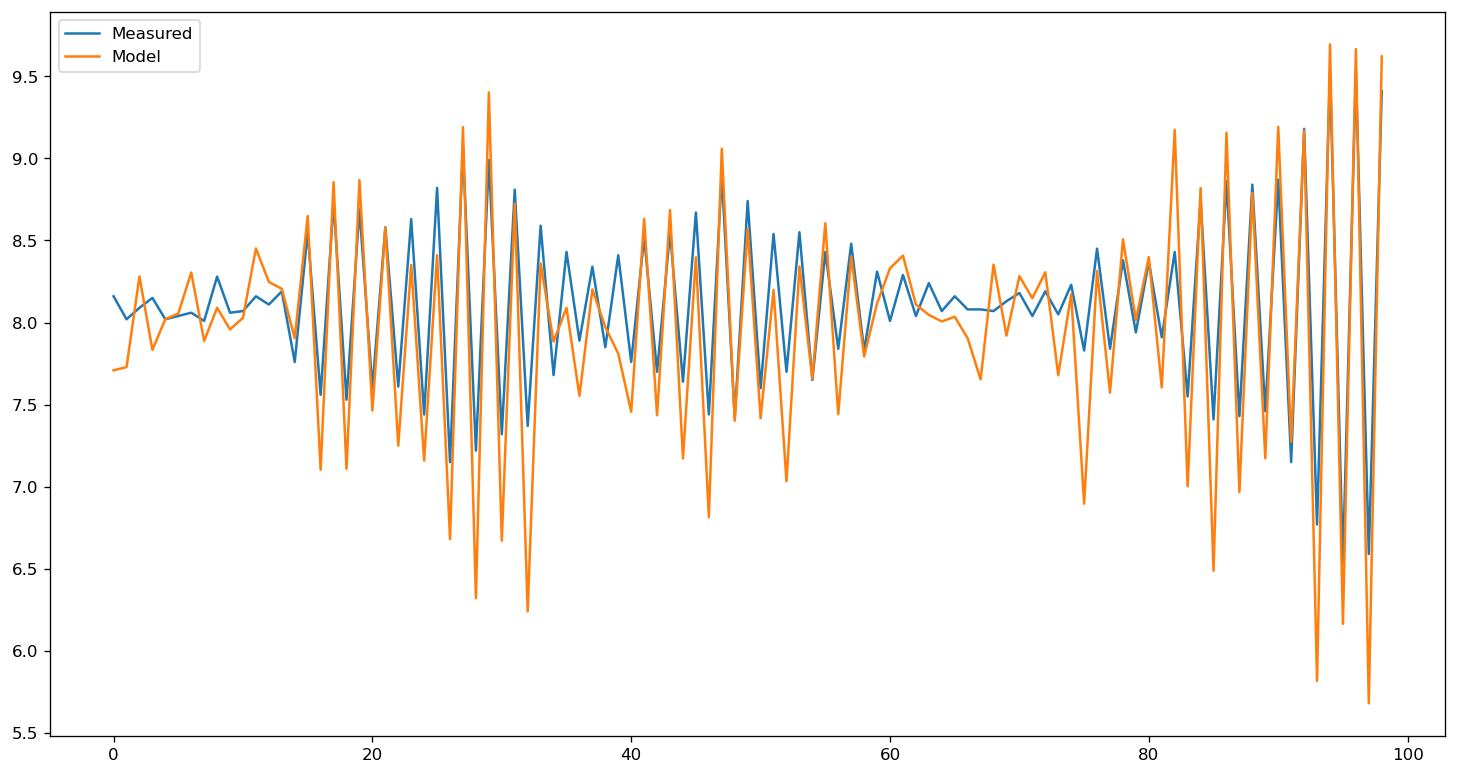

In [471]:
sample_pred_y = adam_model(sample_x)

plt.figure(dpi=120, figsize=(15, 8))
measured_l, = plt.plot(range(0, len(sample_pred_y)), sample_y)
model_l, = plt.plot(range(0, len(sample_pred_y)), sample_pred_y)
plt.legend([measured_l, model_l], ('Measured', 'Model'))
plt.show()